# Load Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load Data

In [ ]:
# Run this only when you run the script using google colaboratory
from google.colab import drive
drive.mount('/content/drive')

import os
# adjust the path with your own google drive folder path
os.chdir("/content/drive/My Drive/Webinar/rfm_segmentation")

In [2]:
# download dataset https://www.kaggle.com/carrie1/ecommerce-data
dataset = pd.read_csv("ecommerce_data.csv",encoding= 'unicode_escape')
dataset

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.00,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.00,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.00,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.00,France


# Dataset Preprocessing

In [3]:
# remove rows that have missing value
dataset = dataset.dropna()

# preprocess datatype and add some new features
dataset["Sales"] = dataset["Quantity"] * dataset["UnitPrice"]
dataset["InvoiceDate"] = pd.to_datetime(dataset["InvoiceDate"])
dataset["CustomerID"] = dataset["CustomerID"].astype("int64")
dataset["InvoiceDate_date"] = dataset["InvoiceDate"].dt.date
dataset["monthyear"] = pd.to_datetime(dataset["InvoiceDate"]).dt.to_period('M').dt.to_timestamp()
dataset = dataset[dataset.Sales>0]

# define month year period
dataset = dataset[dataset.monthyear<"2011-12"]

dataset

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,InvoiceDate_date,monthyear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,1.25,15444,United Kingdom,5.00,2011-11-30,2011-11-01
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37:00,5.95,15444,United Kingdom,11.90,2011-11-30,2011-11-01
516366,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.08,15444,United Kingdom,12.48,2011-11-30,2011-11-01
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37:00,7.95,15444,United Kingdom,7.95,2011-11-30,2011-11-01


# Dataset Exploration

In [4]:
# see the data distribution each month
sales_monthly = dataset.groupby("monthyear").agg({"Sales":"sum","CustomerID":"nunique","InvoiceNo":"nunique"}).reset_index()
sales_monthly["Sales_per_trx"] = sales_monthly["Sales"] / sales_monthly["InvoiceNo"]
sales_monthly

,monthyear,Sales,CustomerID,InvoiceNo,Sales_per_trx
0,2010-12-01,572713.89,885,1400,409.08
1,2011-01-01,569445.04,741,987,576.95
2,2011-02-01,447137.35,758,997,448.48
3,2011-03-01,595500.76,974,1321,450.80
4,2011-04-01,469200.36,856,1149,408.36
5,2011-05-01,678594.56,1056,1555,436.40
6,2011-06-01,661213.69,991,1393,474.67
7,2011-07-01,600091.01,949,1331,450.86
8,2011-08-01,645343.90,935,1280,504.17
9,2011-09-01,952838.38,1266,1755,542.93


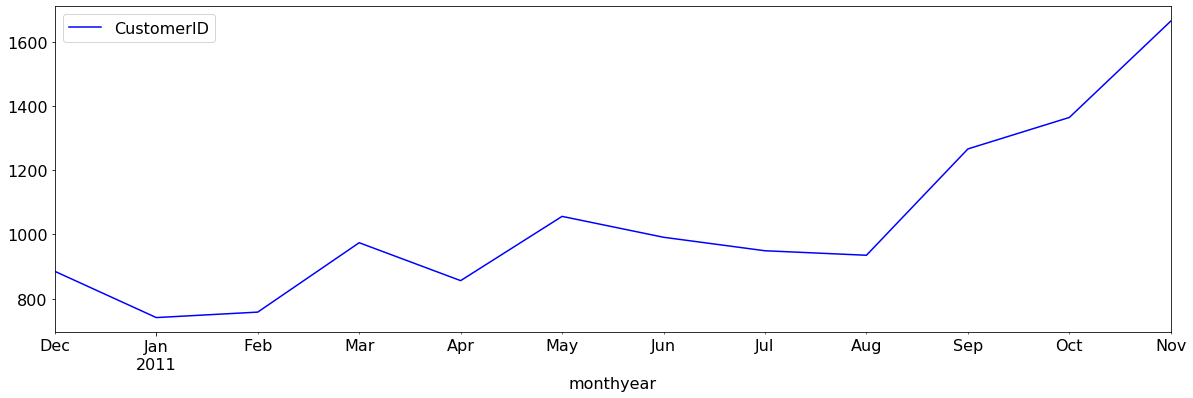

In [5]:
# plot customer
plt.rcParams["figure.figsize"] = [20, 6]
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = False
sales_monthly.plot(kind='line',x='monthyear',y='CustomerID',color='blue')
plt.show()

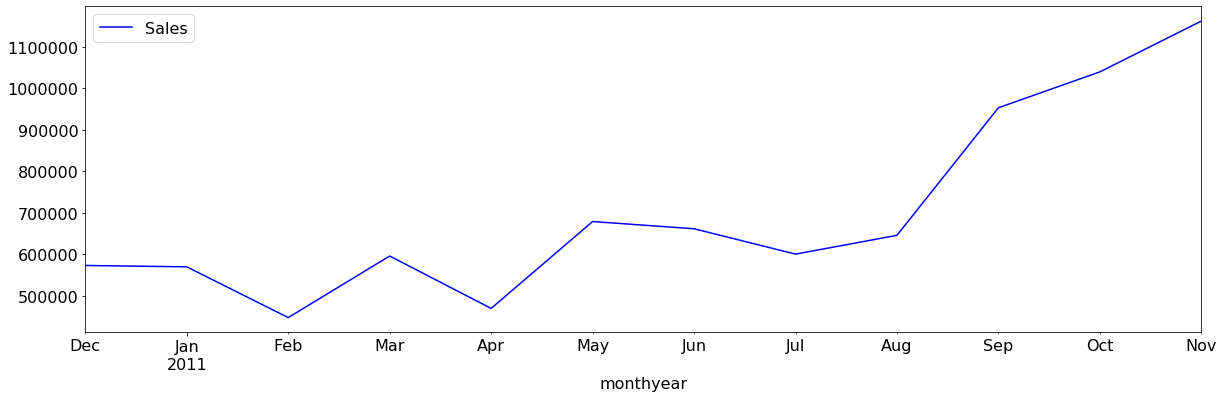

In [6]:
# plot sales
plt.rcParams["figure.figsize"] = [20, 6]
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = False
sales_monthly.plot(kind='line',x='monthyear',y='Sales',color='blue')
plt.show()

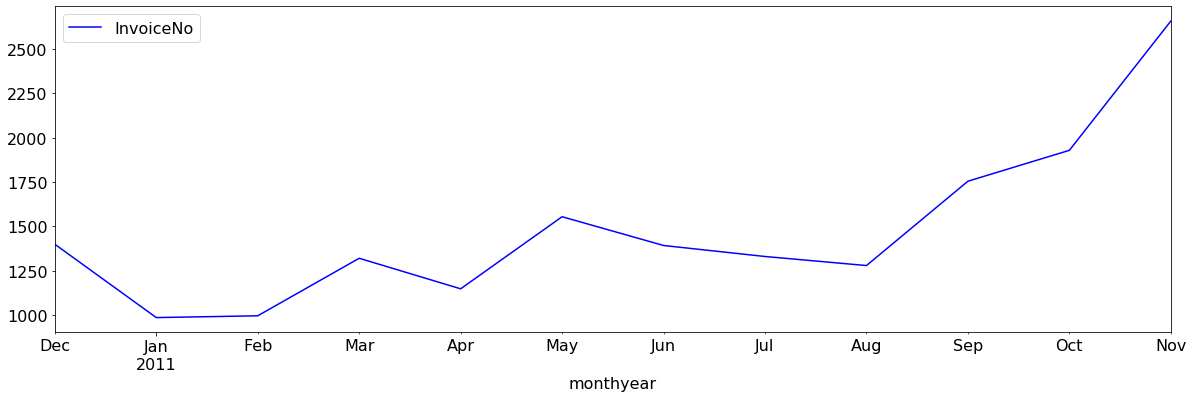

In [7]:
# plot invoice
plt.rcParams["figure.figsize"] = [20, 6]
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = False
sales_monthly.plot(kind='line',x='monthyear',y='InvoiceNo',color='blue')
plt.show()

In [8]:
# Calculate Recency (month), Frequency (unique InvoiceNo), and Monetary (Sales) by Customer ID
customer_agg = dataset.groupby("CustomerID").agg({"monthyear":"max","Sales":"sum","InvoiceNo":"nunique"}).reset_index()
customer_agg.columns = ["CustomerID","last_month","Monetary","Frequency"]

customer_agg["Recency"] =  ((pd.to_datetime("2011-12-01")  - customer_agg["last_month"])/np.timedelta64(1, 'M')).round().astype("int")
customer_agg

,CustomerID,last_month,Monetary,Frequency,Recency
0,12346,2011-01-01,77183.60,1,11
1,12347,2011-10-01,4085.18,6,2
2,12348,2011-09-01,1797.24,4,3
3,12349,2011-11-01,1757.55,1,1
4,12350,2011-02-01,334.40,1,10
...,...,...,...,...,...
4292,18280,2011-03-01,180.60,1,9
4293,18281,2011-06-01,80.82,1,6
4294,18282,2011-08-01,100.21,1,4
4295,18283,2011-11-01,1886.88,15,1


In [9]:
# see the Recency, Frequency, and Monetary distribution
customer_agg[["Recency","Frequency","Monetary"]].describe()

,Recency,Frequency,Monetary
count,4297.00,4297.00,4297.00
mean,3.53,4.13,1953.27
std,3.18,7.41,8355.83
min,1.00,1.00,2.90
25%,1.00,1.00,304.47
50%,2.00,2.00,657.30
75%,5.00,4.00,1600.86
max,12.00,200.00,268478.00


In [ ]:
# Recency Distribution
recency_dist = customer_agg.groupby("Recency").agg({"CustomerID":"nunique"}).reset_index()
recency_dist.plot(kind='bar',x='Recency',y='CustomerID',color='orange',ylabel='Unique Customer')

In [ ]:
# Frequency Distribution
frequency_dist = customer_agg.groupby("Frequency").agg({"CustomerID":"nunique"}).reset_index()
frequency_dist.plot(kind='bar',x='Frequency',y='CustomerID',color='blue',ylabel='Unique Customer')

# Clustering using Rule-based

In [10]:
# https://www.datacamp.com/community/tutorials/introduction-customer-segmentation-python
# divide Recency, Frequency, and Monetary into 3 groups using quartile

customer_agg["Recency_rank"] = customer_agg['Recency'].rank(method='first')
customer_agg["Frequency_rank"] = customer_agg['Frequency'].rank(method='first')
customer_agg["Monetary_rank"] = customer_agg['Monetary'].rank(method='first')

customer_agg['r_group'] = pd.qcut(customer_agg['Recency_rank'], 3, ['High','Medium','Low'])
customer_agg['f_group'] = pd.qcut(customer_agg['Frequency_rank'], 3, ['Low','Medium','High'])
customer_agg['m_group'] = pd.qcut(customer_agg['Monetary_rank'], 3, ['Low','Medium','High'])

customer_agg[["CustomerID","Recency","Frequency","Monetary","r_group","f_group","m_group"]]

,CustomerID,Recency,Frequency,Monetary,r_group,f_group,m_group
0,12346,11,1,77183.60,Low,Low,High
1,12347,2,6,4085.18,Medium,High,High
2,12348,3,4,1797.24,Medium,Medium,High
3,12349,1,1,1757.55,High,Low,High
4,12350,10,1,334.40,Low,Low,Low
...,...,...,...,...,...,...,...
4292,18280,9,1,180.60,Low,Medium,Low
4293,18281,6,1,80.82,Low,Medium,Low
4294,18282,4,1,100.21,Low,Medium,Low
4295,18283,1,15,1886.88,Medium,High,High


In [11]:
# https://medium.com/capillary-data-science/rfm-analysis-an-effective-customer-segmentation-technique-using-python-58804480d232
# label the segment based on rule based for each Recency, Frequency, or Monetary combination

customer_agg["rfm_segment"] = None
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.r_group=="High")&(customer_agg.f_group=="High")\
                 &(customer_agg.m_group=="High"),"rfm_segment"] = "1. Champion"
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.f_group=="High"),"rfm_segment"] = "2. Loyal"
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.m_group=="High"),"rfm_segment"] = "3. Big Spender"
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.r_group=="High"),"rfm_segment"] = "4. Recent"
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.r_group=="Low"),"rfm_segment"] = "6. Sleeping"
customer_agg.loc[(customer_agg.rfm_segment.isnull()),"rfm_segment"] = "5. Regular"

customer_agg[["CustomerID","Recency","Frequency","Monetary","r_group","f_group","m_group","rfm_segment"]]

,CustomerID,Recency,Frequency,Monetary,r_group,f_group,m_group,rfm_segment
0,12346,11,1,77183.60,Low,Low,High,3. Big Spender
1,12347,2,6,4085.18,Medium,High,High,2. Loyal
2,12348,3,4,1797.24,Medium,Medium,High,3. Big Spender
3,12349,1,1,1757.55,High,Low,High,3. Big Spender
4,12350,10,1,334.40,Low,Low,Low,6. Sleeping
...,...,...,...,...,...,...,...,...
4292,18280,9,1,180.60,Low,Medium,Low,6. Sleeping
4293,18281,6,1,80.82,Low,Medium,Low,6. Sleeping
4294,18282,4,1,100.21,Low,Medium,Low,6. Sleeping
4295,18283,1,15,1886.88,Medium,High,High,2. Loyal


In [12]:
# see segment distribution
segment_dist = customer_agg.groupby("rfm_segment").agg({"CustomerID":"nunique",\
                                                        "Recency":["min","max","mean"],"Frequency":["min","max","mean"],\
                                                        "Monetary":["min","max","mean"]}).reset_index()
segment_dist

rfm_segment CustomerID Recency          Frequency            Monetary  \
                     nunique     min max mean       min  max  mean      min   
0     1. Champion        676       1   1 1.00         4  200 11.91  1158.30   
1        2. Loyal        756       1  12 2.43         4  120  6.59    36.56   
2  3. Big Spender        317       1  12 3.19         1    4  2.38  1158.29   
3       4. Recent        517       1   1 1.00         1    3  1.80    20.80   
4      5. Regular        826       1   4 2.23         1    3  1.64     6.20   
5     6. Sleeping       1205       4  12 7.70         1    3  1.40     2.90   

                     
        max    mean  
0 268478.00 6667.64  
1 248171.76 2678.98  
2  77183.60 2542.93  
3   1134.28  461.94  
4   1156.36  466.28  
5   1145.84  357.27

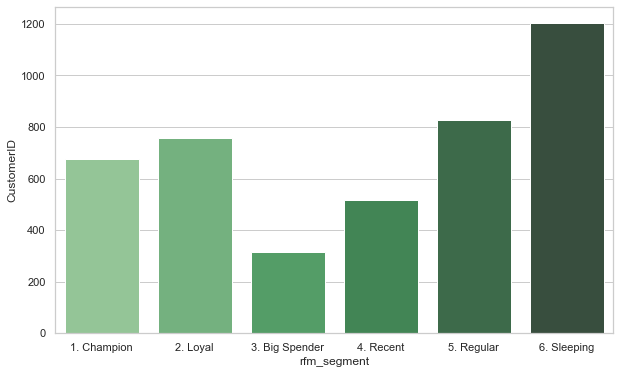

In [13]:
# visual the unique customer per segment  
user_dist = customer_agg.groupby("rfm_segment").agg({"CustomerID":"nunique"}).reset_index()
plt.rcParams["figure.figsize"] = [10, 6]
sns.set_theme(style="whitegrid", font_scale=1)
sns.barplot(data=user_dist,x='rfm_segment',y='CustomerID',palette="Greens_d",orient="v")

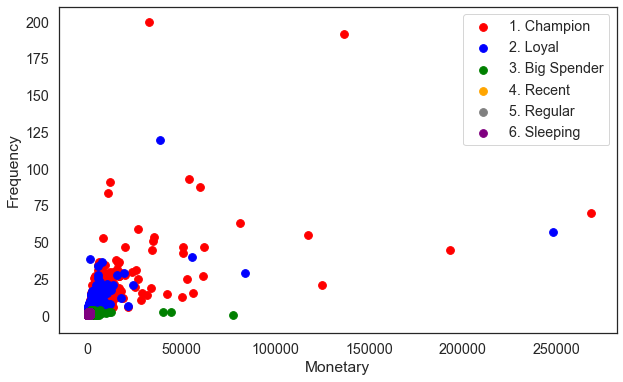

In [14]:
# 2d visualization
X = customer_agg

# Monetary x Frequency
plt.rcParams["figure.figsize"] = [10, 6]
sns.set_theme(style="white", font_scale=1.3)
plt.scatter(X[X.rfm_segment == "1. Champion"].Monetary, X[X.rfm_segment == "1. Champion"].Frequency, s = 60, c = 'red', label = '1. Champion')
plt.scatter(X[X.rfm_segment == "2. Loyal"].Monetary, X[X.rfm_segment == "2. Loyal"].Frequency, s = 60, c = 'blue', label = '2. Loyal')
plt.scatter(X[X.rfm_segment == "3. Big Spender"].Monetary, X[X.rfm_segment == "3. Big Spender"].Frequency, s = 60, c = 'green', label = '3. Big Spender')
plt.scatter(X[X.rfm_segment == "4. Rookies"].Monetary, X[X.rfm_segment == "4. Rookies"].Frequency, s = 60, c = 'orange', label = '4. Recent')
plt.scatter(X[X.rfm_segment == "5. Regular"].Monetary, X[X.rfm_segment == "5. Regular"].Frequency, s = 60, c = 'gray', label = '5. Regular')
plt.scatter(X[X.rfm_segment == "6. Sleeping"].Monetary, X[X.rfm_segment == "6. Sleeping"].Frequency, s = 60, c = 'purple', label = '6. Sleeping')
plt.xlabel('Monetary') 
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

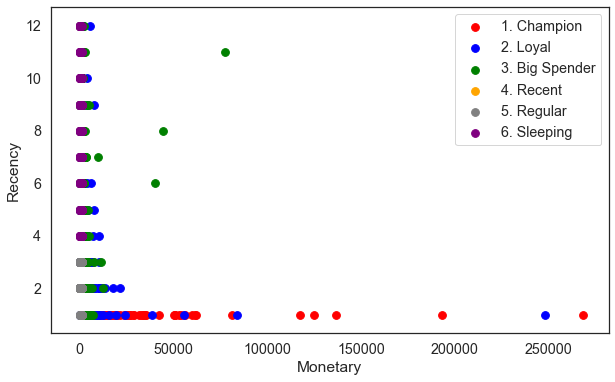

In [15]:
# Monetary x Recency
plt.scatter(X[X.rfm_segment == "1. Champion"].Monetary, X[X.rfm_segment == "1. Champion"].Recency, s = 60, c = 'red', label = '1. Champion')
plt.scatter(X[X.rfm_segment == "2. Loyal"].Monetary, X[X.rfm_segment == "2. Loyal"].Recency, s = 60, c = 'blue', label = '2. Loyal')
plt.scatter(X[X.rfm_segment == "3. Big Spender"].Monetary, X[X.rfm_segment == "3. Big Spender"].Recency, s = 60, c = 'green', label = '3. Big Spender')
plt.scatter(X[X.rfm_segment == "4. Rookies"].Monetary, X[X.rfm_segment == "4. Rookies"].Recency, s = 60, c = 'orange', label = '4. Recent')
plt.scatter(X[X.rfm_segment == "5. Regular"].Monetary, X[X.rfm_segment == "5. Regular"].Recency, s = 60, c = 'gray', label = '5. Regular')
plt.scatter(X[X.rfm_segment == "6. Sleeping"].Monetary, X[X.rfm_segment == "6. Sleeping"].Recency, s = 60, c = 'purple', label = '6. Sleeping')
plt.xlabel('Monetary') 
plt.ylabel('Recency') 
plt.legend() 
plt.show()

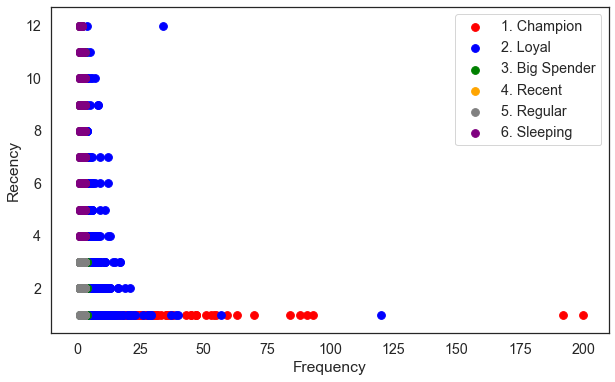

In [16]:
# Frequency x Recency
plt.scatter(X[X.rfm_segment == "1. Champion"].Frequency, X[X.rfm_segment == "1. Champion"].Recency, s = 60, c = 'red', label = '1. Champion')
plt.scatter(X[X.rfm_segment == "2. Loyal"].Frequency, X[X.rfm_segment == "2. Loyal"].Recency, s = 60, c = 'blue', label = '2. Loyal')
plt.scatter(X[X.rfm_segment == "3. Big Spender"].Frequency, X[X.rfm_segment == "3. Big Spender"].Recency, s = 60, c = 'green', label = '3. Big Spender')
plt.scatter(X[X.rfm_segment == "4. Rookies"].Frequency, X[X.rfm_segment == "4. Rookies"].Recency, s = 60, c = 'orange', label = '4. Recent')
plt.scatter(X[X.rfm_segment == "5. Regular"].Frequency, X[X.rfm_segment == "5. Regular"].Recency, s = 60, c = 'gray', label = '5. Regular')
plt.scatter(X[X.rfm_segment == "6. Sleeping"].Frequency, X[X.rfm_segment == "6. Sleeping"].Recency, s = 60, c = 'purple', label = '6. Sleeping')
plt.xlabel('Frequency') 
plt.ylabel('Recency') 
plt.legend() 
plt.show()

# Clustering using K-Means

In [17]:
# https://s3.amazonaws.com/assets.datacamp.com/production/course_10628/slides/chapter3.pdf
# since the data are skewed, we transform it to log 
customer_agg["Monetary_log"]= np.log(customer_agg[['Monetary']])
customer_agg["Frequency_log"]= np.log(customer_agg[['Frequency']])
customer_agg["Recency_log"]= np.log(customer_agg[['Recency']])
customer_agg

,CustomerID,last_month,Monetary,Frequency,Recency,Recency_rank,Frequency_rank,Monetary_rank,r_group,f_group,m_group,rfm_segment,Monetary_log,Frequency_log,Recency_log
0,12346,2011-01-01,77183.60,1,11,4077.00,1.00,4289.00,Low,Low,High,3. Big Spender,11.25,0.00,2.40
1,12347,2011-10-01,4085.18,6,2,1665.00,3469.00,3957.00,Medium,High,High,2. Loyal,8.32,1.79,0.69
2,12348,2011-09-01,1797.24,4,3,2407.00,2860.00,3349.00,Medium,Medium,High,3. Big Spender,7.49,1.39,1.10
3,12349,2011-11-01,1757.55,1,1,1.00,2.00,3320.00,High,Low,High,3. Big Spender,7.47,0.00,0.00
4,12350,2011-02-01,334.40,1,10,3964.00,3.00,1240.00,Low,Low,Low,6. Sleeping,5.81,0.00,2.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4292,18280,2011-03-01,180.60,1,9,3963.00,1536.00,570.00,Low,Medium,Low,6. Sleeping,5.20,0.00,2.20
4293,18281,2011-06-01,80.82,1,6,3471.00,1537.00,103.00,Low,Medium,Low,6. Sleeping,4.39,0.00,1.79
4294,18282,2011-08-01,100.21,1,4,3085.00,1538.00,157.00,Low,Medium,Low,6. Sleeping,4.61,0.00,1.39
4295,18283,2011-11-01,1886.88,15,1,1664.00,4147.00,3397.00,Medium,High,High,2. Loyal,7.54,2.71,0.00


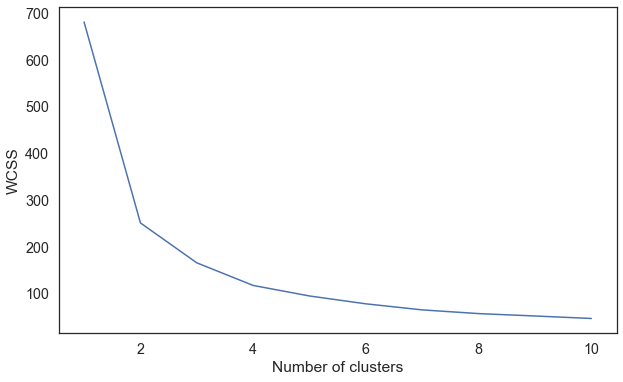

In [18]:
# Find k using elbow method
# https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/
# Inertia: It is the sum of squared distances of samples to their closest cluster center.

# K-means
dataset_array = customer_agg[["Monetary_log","Frequency_log","Recency_log"]].values
scaler = MinMaxScaler()

X_scaled=scaler.fit_transform(dataset_array)
wcss = [] 
for i in range(1, 11): 
    k_model =  KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    k_model.fit(X_scaled)
    wcss.append(k_model.inertia_)

plt.rcParams["figure.figsize"] = [10, 6]
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show(wcss)

In [19]:
# K-means
dataset_array = customer_agg[["Monetary_log","Frequency_log","Recency_log"]].values
scaler = MinMaxScaler()

X_scaled=scaler.fit_transform(dataset_array)

k_model = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
k_model.fit(X_scaled)

predicted_values = k_model.predict(X_scaled)

predicted_values = pd.DataFrame(predicted_values, columns=["cluster_segment"])
dataset_cluster = pd.concat([customer_agg,predicted_values], axis=1)

In [20]:
# cluster distribution
cluster_dist = dataset_cluster.groupby("cluster_segment").agg({"CustomerID":"nunique","Frequency":["min","max","mean"],\
                                                               "Monetary":["min","max","mean"],\
                                                               "Recency":["min","max","mean"]}).reset_index()
cluster_dist

cluster_segment CustomerID Frequency            Monetary                    \
                     nunique       min  max  mean      min       max    mean   
0               0       1200         1   34  1.62     2.90  77183.60  624.47   
1               1        887         1    7  2.32    20.80   6207.67  719.61   
2               2       1331         1   17  2.56     6.20  12601.83  979.69   
3               3        879         3  200 11.77   621.68 268478.00 6486.46   

  Recency           
      min max mean  
0       4  12 8.07  
1       1   1 1.00  
2       2   5 2.71  
3       1   3 1.12

In [21]:
# Cluster Labeling
dataset_cluster.loc[dataset_cluster.cluster_segment==3,"rfm_segment"] = "1. Champion"
dataset_cluster.loc[dataset_cluster.cluster_segment==1,"rfm_segment"] = "2. Recent"
dataset_cluster.loc[dataset_cluster.cluster_segment==2,"rfm_segment"] = "3. Regular"
dataset_cluster.loc[dataset_cluster.cluster_segment==0,"rfm_segment"] = "4. Sleeping"
dataset_cluster

,CustomerID,last_month,Monetary,Frequency,Recency,Recency_rank,Frequency_rank,Monetary_rank,r_group,f_group,m_group,rfm_segment,Monetary_log,Frequency_log,Recency_log,cluster_segment
0,12346,2011-01-01,77183.60,1,11,4077.00,1.00,4289.00,Low,Low,High,4. Sleeping,11.25,0.00,2.40,0
1,12347,2011-10-01,4085.18,6,2,1665.00,3469.00,3957.00,Medium,High,High,1. Champion,8.32,1.79,0.69,3
2,12348,2011-09-01,1797.24,4,3,2407.00,2860.00,3349.00,Medium,Medium,High,3. Regular,7.49,1.39,1.10,2
3,12349,2011-11-01,1757.55,1,1,1.00,2.00,3320.00,High,Low,High,2. Recent,7.47,0.00,0.00,1
4,12350,2011-02-01,334.40,1,10,3964.00,3.00,1240.00,Low,Low,Low,4. Sleeping,5.81,0.00,2.30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4292,18280,2011-03-01,180.60,1,9,3963.00,1536.00,570.00,Low,Medium,Low,4. Sleeping,5.20,0.00,2.20,0
4293,18281,2011-06-01,80.82,1,6,3471.00,1537.00,103.00,Low,Medium,Low,4. Sleeping,4.39,0.00,1.79,0
4294,18282,2011-08-01,100.21,1,4,3085.00,1538.00,157.00,Low,Medium,Low,3. Regular,4.61,0.00,1.39,2
4295,18283,2011-11-01,1886.88,15,1,1664.00,4147.00,3397.00,Medium,High,High,1. Champion,7.54,2.71,0.00,3


In [22]:
# cluster distribution
cluster_dist = dataset_cluster.groupby("rfm_segment").agg({"CustomerID":"nunique",\
                                                           "Frequency":["min","max","mean"],\
                                                           "Monetary":["min","max","mean"],\
                                                           "Recency":["min","max","mean"]}).reset_index()
cluster_dist

rfm_segment CustomerID Frequency            Monetary                    \
                  nunique       min  max  mean      min       max    mean   
0  1. Champion        879         3  200 11.77   621.68 268478.00 6486.46   
1    2. Recent        887         1    7  2.32    20.80   6207.67  719.61   
2   3. Regular       1331         1   17  2.56     6.20  12601.83  979.69   
3  4. Sleeping       1200         1   34  1.62     2.90  77183.60  624.47   

  Recency           
      min max mean  
0       1   3 1.12  
1       1   1 1.00  
2       2   5 2.71  
3       4  12 8.07

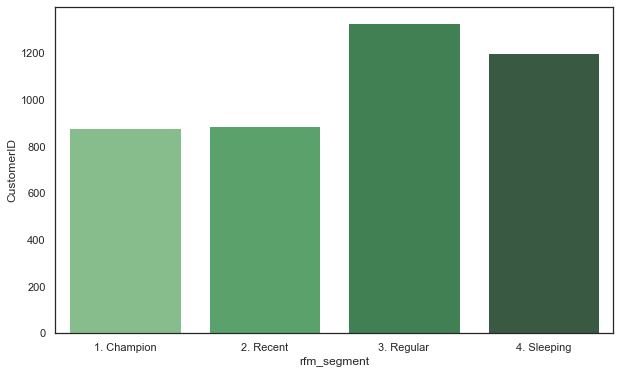

In [23]:
# plot the unique customer
user_dist = dataset_cluster.groupby("rfm_segment").agg({"CustomerID":"nunique"}).reset_index()
plt.rcParams["figure.figsize"] = [10, 6]
sns.set_theme(style="white", font_scale=1)
sns.barplot(data=user_dist,x='rfm_segment',y='CustomerID',palette="Greens_d",orient="v")

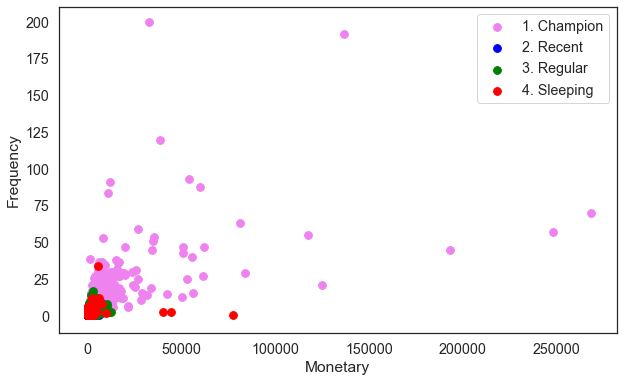

In [28]:
# 2d visualization
X = dataset_cluster

# Monetary x Frequency
plt.rcParams["figure.figsize"] = [10, 6]
sns.set_theme(style="white", font_scale=1.3)
plt.scatter(X[X.cluster_segment == 3].Monetary, X[X.cluster_segment == 3].Frequency, s = 60, c = 'violet', label = '1. Champion')
plt.scatter(X[X.cluster_segment == 1].Monetary, X[X.cluster_segment == 1].Frequency, s = 60, c = 'blue', label = '2. Recent')
plt.scatter(X[X.cluster_segment == 2].Monetary, X[X.cluster_segment == 2].Frequency, s = 60, c = 'green', label = '3. Regular')
plt.scatter(X[X.cluster_segment == 0].Monetary, X[X.cluster_segment == 0].Frequency, s = 60, c = 'red', label = '4. Sleeping')
plt.xlabel('Monetary') 
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

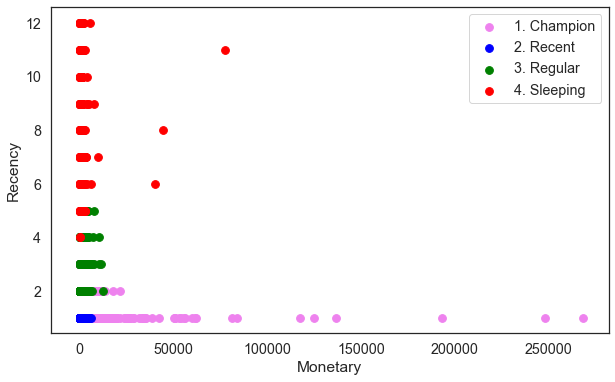

In [26]:
# Monetary x Recency
plt.scatter(X[X.cluster_segment == 3].Monetary, X[X.cluster_segment == 3].Recency, s = 60, c = 'violet', label = '1. Champion')
plt.scatter(X[X.cluster_segment == 1].Monetary, X[X.cluster_segment == 1].Recency, s = 60, c = 'blue', label = '2. Recent')
plt.scatter(X[X.cluster_segment == 2].Monetary, X[X.cluster_segment == 2].Recency, s = 60, c = 'green', label = '3. Regular')
plt.scatter(X[X.cluster_segment == 0].Monetary, X[X.cluster_segment == 0].Recency, s = 60, c = 'red', label = '4. Sleeping')
plt.xlabel('Monetary') 
plt.ylabel('Recency') 
plt.legend() 
plt.show()

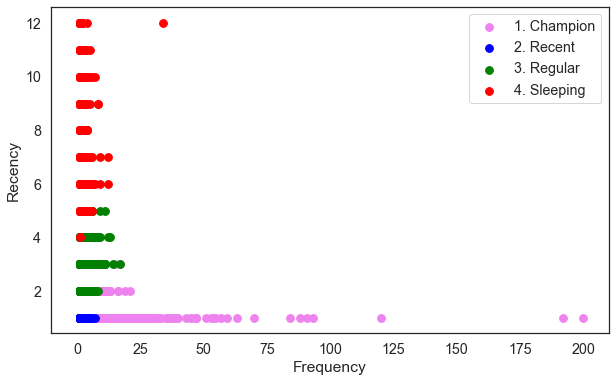

In [27]:
# Monetary x Frequency
plt.scatter(X[X.cluster_segment == 3].Frequency, X[X.cluster_segment == 3].Recency, s = 60, c = 'violet', label = '1. Champion')
plt.scatter(X[X.cluster_segment == 1].Frequency, X[X.cluster_segment == 1].Recency, s = 60, c = 'blue', label = '2. Recent')
plt.scatter(X[X.cluster_segment == 2].Frequency, X[X.cluster_segment == 2].Recency, s = 60, c = 'green', label = '3. Regular')
plt.scatter(X[X.cluster_segment == 0].Frequency, X[X.cluster_segment == 0].Recency, s = 60, c = 'red', label = '4. Sleeping')
plt.xlabel('Frequency') 
plt.ylabel('Recency') 
plt.legend() 
plt.show()

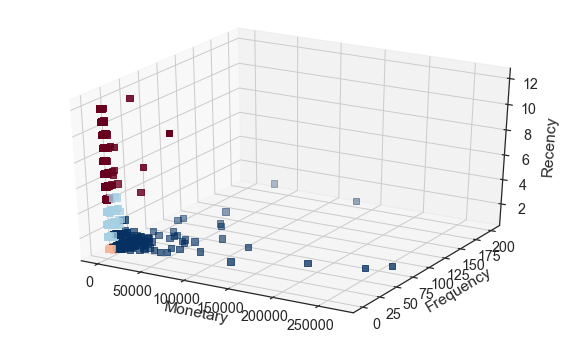

In [29]:
# 3d visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(dataset_cluster['Monetary'])
y = np.array(dataset_cluster['Frequency'])
z = np.array(dataset_cluster['Recency'])

xLabel = ax.set_xlabel('Monetary')
yLabel = ax.set_ylabel('Frequency')
zLabel = ax.set_zlabel('Recency')

ax.scatter(x,y,z, marker="s", c=dataset_cluster["cluster_segment"], s=40, cmap="RdBu")
plt.rcParams["figure.figsize"] = [20, 15]

plt.show()